In [1]:
from numpy.polynomial import Polynomial as pm


class BasicBasisGenerator:
    def __init__(self, degree):
        self.degree = degree

    def basis_smoothed_chebyshev(self, degree):
        if not degree:
            return pm([1])
        elif degree == 1:
            return pm([-1, 2])
        else:
            return pm([-2, 4]) * self.basis_smoothed_chebyshev(degree - 1) - self.basis_smoothed_chebyshev(degree - 2)

    def basis_smoothed_legendre(self, degree):
        n = degree - 1
        if not degree or degree == 0:
            return pm([1])
        elif degree == 1:
            return pm([0, 1])
        else:
            return pm([(2 * n + 1)/(n + 1)]) * pm([0,1]) * self.basis_smoothed_legendre(n) - (n/(n+1)) * self.basis_smoothed_legendre(n - 1)

    def basis_laguerre(self, degree):
        k = degree - 1
        if not degree or degree == 0:
            return pm([1])
        elif degree == 1:
            return pm([1, -1])
        else:
            return (1/(k+1)) * (pm([2 * k + 1, -1]) * self.basis_laguerre(k) - k*self.basis_laguerre(k-1))

    def basis_hermite(self, degree):
        if not degree:
            return pm([1])
        elif degree == 1:
            return pm([0, 2])
        else:
            return pm([0, 2]) * self.basis_hermite(degree - 1) - 2 * (degree - 1) * self.basis_hermite(degree - 2)


class BasisGenerator(BasicBasisGenerator):
    def __init__(self, degree, type):
        super().__init__(degree)
        self.type = type

    def _init_generator(self):
        generators_mapping = {'laguerre': self.basis_laguerre,
                              'hermite': self.basis_hermite,
                              'smoothed_legandr': self.basis_smoothed_legendre,
                              'smoothed_chebyshev': self.basis_smoothed_chebyshev}

        return generators_mapping

    def generate(self):
        generator = self._init_generator().get(self.type)
        for deg in range(self.degree):
            yield generator(deg)

In [2]:
import pandas as pd
from basis_generators import BasisGenerator
from functools import reduce
from optimization_methods import *
import itertools
import numpy as np
from custom_exceptions import *
from scipy.sparse.linalg import cg
from sklearn.linear_model import Lasso, Ridge, LinearRegression


class Solve(object):

    def __init__(self, d):
        self.n = d['samples']
        self.deg = d['dimensions']
        self.filename_input = d['input_file']
        self.filename_output = d['output_file']
        self.p = d['degrees']
        self.weights = d['weights']
        self.poly_type = d['poly_type']
        self.splitted_lambdas = d['lambda_multiblock']
        self.solving_method = d['method']
        self.eps = 1E-6
        self.norm_error = 0.0
        self.error = 0.0

    def _prepare_data(self):
        new_cols = list(
            itertools.chain(*[['X{}'.format(i + 1)] * self.deg[i] if i != len(self.deg) - 1 else ['Y'] * self.deg[i]
                              for i in range(len(self.deg))]))
        new_cols = list(itertools.chain(*np.unique([[el + str(i)
                                                     for i in range(1, new_cols.count(el) + 1)] for el in new_cols])))
        dt = pd.read_csv(self.filename_input, sep='\t', header=None).astype(float)
        dt.columns = new_cols
        return dt

    def _minimize_equation(self, A, b):
        """
        Finds such vector x that |Ax-b|->min.
        :param A: Matrix A
        :param b: Vector b
        :return: Vector x
        """
        if self.solving_method == 'LSTM':
            return np.linalg.lstsq(A, b)[0]
        elif self.solving_method == 'conjucate':
            return cg(np.dot(A, A.T), b, tol=self.eps)[0] #conjugate_gradient_method(A, b, self.eps)
        elif self.solving_method == 'coordDesc':
            return Lasso().fit(A, b).coef_ #coordinate_descent(A, b, self.eps) #Ridge().fit(A, b).coef_
        else:
            raise MethodNotFilledException

    def _norm_data(self, data):
        normalized_data = data.copy(deep=True)
        agg = normalized_data.agg([min, max])

        for col in normalized_data.columns:
            min_val = agg.loc['min', col]
            max_val = agg.loc['max', col]
            normalized_data[col] = normalized_data[col].apply(lambda x: (x - min_val) / (max_val - min_val))

        return normalized_data

    def _create_train_dataset(self, data):
        '''
        build matrix X and Y
        :return:
        '''
        X = data.loc[:, [el for el in data.columns if el.find('X') != -1]]
        Y = data.loc[:, [el for el in data.columns if el.find('Y') != -1]]

        return X, Y

    def _get_B(self, Y):
        if self.weights == 'average':
            Y = (Y.max(axis=1) + Y.min(axis=1)) / 2  # arguable, may be need not to normalize Y before this operation
            return np.tile(Y.values, (1, self.deg[-1])).reshape((self.n, self.deg[-1]))
        elif self.weights == 'width_interval':
            return np.tile((Y.max(axis=1) - Y.min(axis=1)).values, (1, self.deg[-1])
                    ).reshape((self.n, self.deg[-1]))  # arguable (same as above)
        elif self.weights == 'scaled':
            return Y

    def _evaluate_polynom(self, coefs, x):
        return sum([np.array(coef) * pow(x, i) for i, coef in enumerate(coefs)])

    def _get_A(self, data, polynoms_degrees):
        A = pd.DataFrame()
        for i, degree in enumerate(polynoms_degrees):
            gen = BasisGenerator(degree, self.poly_type)
            coefs = list(map(lambda x: x, list(gen.generate())[-1]))
            A = pd.concat([A, data.apply(lambda x: self._evaluate_polynom(coefs, x))], axis=1)
        return A

    def _get_lambdas(self, A, Y):
        lambdas = pd.DataFrame(columns=['lambda_{}'.format(i) for i in range(1, self.deg[-1])])
        A = pd.DataFrame(A)
        Y = pd.DataFrame(Y)
        for i, j in itertools.product(range(self.deg[-1]), range(len(self.deg) - 1)):
            if self.splitted_lambdas:
                use_cols = [el for el in A.columns if el.find('X{}'.format(j + 1)) != -1]
                train_data = A.loc[:, use_cols]
                a = train_data.T * Y.loc[:, Y.columns[i]]
                lambdas.loc[i, lambdas.columns[j]] = [self._minimize_equation(a.T.values, Y.loc[:, Y.columns[i]])]
            else:
                a = A.T * Y.loc[:, Y.columns[i]]
                lambdas.loc[i, lambdas.columns[j]] = [self._minimize_equation(a.T.values, Y.loc[:, Y.columns[i]])]
        return lambdas

    def _get_psi(self, A, lambdas):
        if self.solving_method == 'LSTM':
            if self.splitted_lambdas:
                psi = [[A.loc[:, [el for el in A.columns if el.find('X{}'.format(i + 1)) != -1]
                        ] * lambdas.loc[j, 'lambda_{}'.format(i + 1)][0] for i in range(len(self.deg) - 1)] for j in
                       range(self.deg[-1])]
            else:
                psi = [[A * lambdas.loc[j, 'lambda_{}'.format(i + 1)][0] for i in range(len(self.deg) - 1)] for j in
                       range(self.deg[-1])]
        elif self.solving_method == 'conjucate':
            if self.splitted_lambdas:
                psi = [[(A.T.loc[[el for el in A.columns if el.find('X{}'.format(i + 1)) != -1],:
                        ] * lambdas.loc[j, 'lambda_{}'.format(i + 1)][0]).T for i in range(len(self.deg) - 1)] for j in
                       range(self.deg[-1])]
            else:
                psi = [[(A.T * lambdas.loc[j, 'lambda_{}'.format(i + 1)][0]).T for i in range(len(self.deg) - 1)] for j in
                       range(self.deg[-1])]
        else:
            if self.splitted_lambdas:
                psi = [[A.loc[:, [el for el in A.columns if el.find('X{}'.format(i + 1)) != -1]
                        ] * lambdas.loc[j, 'lambda_{}'.format(i + 1)][0] for i in range(len(self.deg) - 1)] for j in
                       range(self.deg[-1])]
            else:
                psi = [[A * lambdas.loc[j, 'lambda_{}'.format(i + 1)][0] for i in range(len(self.deg) - 1)] for j in
                       range(self.deg[-1])]
        return psi

    def _get_A1(self, psi, y):
        y = pd.DataFrame(y)
        return [[self._minimize_equation(psi[i][j][:], y.loc[:, y.columns[i]]) for j in range(len(self.deg) - 1)]
                for i in range(self.deg[-1])]

    def _get_Fi(self, psi, a1):
        if self.solving_method == 'LSTM':
            if self.splitted_lambdas:
                fi = np.array([[psi[i][j] * a1[i][j] for j in range(len(self.deg) - 1)] for i in range(self.deg[-1])])
            else:
                fi = [[psi[i][j] * a1[i][j] for j in range(len(self.deg) - 1)] for i in range(self.deg[-1])]
        elif self.solving_method == 'conjucate':
            if self.splitted_lambdas:
                fi = np.array([[(psi[i][j].T * a1[i][j]).T for j in range(len(self.deg) - 1)] for i in range(self.deg[-1])])
            else:
                fi = [[(psi[i][j].T * a1[i][j]).T for j in range(len(self.deg) - 1)] for i in range(self.deg[-1])]
        else:
            if self.splitted_lambdas:
                fi = np.array([[psi[i][j] * a1[i][j] for j in range(len(self.deg) - 1)] for i in range(self.deg[-1])])
            else:
                fi = [[psi[i][j] * a1[i][j] for j in range(len(self.deg) - 1)] for i in range(self.deg[-1])]
        fi = [reduce(lambda x, y: pd.concat([x, y], axis=1), fi[i]) for i in range(self.deg[-1])]
        return fi

    def _get_coefs(self, fi, y):
        y = pd.DataFrame(y)
        if self.solving_method == 'conjucate':
            return [self._minimize_equation(np.dot(fi[i].T, fi[i]),
                                        np.dot(fi[i].T, y.iloc[:, i])) for i in range(self.deg[-1])]
        else:
            return [self._minimize_equation(fi[i], y.iloc[:, i]) for i in range(self.deg[-1])]

    # TODO Fitness function for normalize version
    def _get_fitness_function(self, fi, y, coefs):
        y = pd.DataFrame(y)
        fitness = [np.dot(fi[i], coefs[i]) for i in range(self.deg[-1])]
        norm_error = [(y.iloc[:, i] - fitness[i]) for i in range(self.deg[-1])]
        return fitness, norm_error

    def _save_data(self, data, norm_data, A, norm_A, lambdas, lambdas_norm, psi, psi_norm,
                   A1, A1_norm, y_new, y_new_normalized, c, c_norm,
                   fit_res, fit_res_norm, errors, errors_norm, nor_errors, nor_errors_norm):
        with pd.ExcelWriter(self.filename_output) as writer:
            data.to_excel(writer, sheet_name='Вхідні дані')
            A.to_excel(writer, sheet_name='Матриця А')
            lambdas.to_excel(writer, sheet_name='Значення лямбд')
            for i in range(len(psi)):
                temp = reduce(lambda x, y: pd.concat([x, y], axis=1), psi[i])
                pd.DataFrame(temp).to_excel(writer, sheet_name='PSI{}'.format(i + 1))
            A1.to_excel(writer, sheet_name='матриця А1')
            y_new.to_excel(writer, sheet_name='Перебудовані Y')
            c.to_excel(writer, sheet_name='Коефіцієнти c')
            fit_res.to_excel(writer, sheet_name='Побудований прогноз')
            errors.to_excel(writer, sheet_name='Похибки')
            nor_errors.to_excel(writer, sheet_name='Норми похибок')

            norm_data.to_excel(writer, sheet_name='Вхідні дані (нормалізований варіант)')
            norm_A.to_excel(writer, sheet_name='Матриця А (нормалізований варіант)')
            lambdas_norm.to_excel(writer, sheet_name='Значення лямбд (нормалізований варіант)')
            for i in range(len(psi_norm)):
                temp = reduce(lambda x, y: pd.concat([x, y], axis=1), psi_norm[i])
                temp.to_excel(writer, sheet_name='PSI{} (нормалізований варіант)'.format(i + 1))
            A1_norm.to_excel(writer, sheet_name='матриця А1 (нормалізований варіант)')
            y_new_normalized.to_excel(writer, sheet_name='Перебудовані Y (нормалізований варіант)')
            c_norm.to_excel(writer, sheet_name='Коефіцієнти c (нормалізований варіант)')
            fit_res_norm.to_excel(writer, sheet_name='Побудований прогноз (нормалізований варіант)')
            errors_norm.to_excel(writer, sheet_name='Похибки (нормалізований варіант)')
            nor_errors_norm.to_excel(writer, sheet_name='Норми похибок (нормалізований варіант)')

    def print_data(self, data, norm_data, A, norm_A, lambdas, lambdas_norm, psi, psi_norm,
                   A1, A1_norm, y_new, y_new_normalized, c, c_norm,
                   fit_res, fit_res_norm, errors, errors_norm, nor_errors, nor_errors_norm, *args):
        text = []
        text.append('Вхідні дані')
        print('Вхідні дані')
        print(data.to_string())
        text.append(data.to_string())
        print('-------------------------')
        text.append('-------------------------')
        print('Матриця А')
        text.append('Матриця А')
        print(A.to_string())
        text.append(A.to_string())
        print('-------------------------')
        text.append('-------------------------')
        print('Значення лямбд')
        text.append('Значення лямбд')
        print(lambdas.to_string())
        text.append(lambdas.to_string())
        print('-------------------------')
        text.append('-------------------------')
        for i in range(len(psi)):
            temp = reduce(lambda x, y: pd.concat([x, y], axis=1), psi[i])
            print('PSI{}'.format(i + 1))
            text.append('PSI{}'.format(i + 1))
            print(temp.to_string())
            text.append(temp.to_string())
            print('---------------------')
            text.append('---------------------')
        print('матриця А1')
        text.append('матриця А1')
        print(A1.to_string())
        text.append(A1.to_string())
        print('-------------------------')
        text.append('-------------------------')
        print('Перебудовані Y')
        text.append('Перебудовані Y')
        print(y_new.to_string())
        text.append(y_new.to_string())
        print('-------------------------')
        text.append('-------------------------')
        print('Коефіцієнти c')
        text.append('Коефіцієнти c')
        print(c.to_string())
        text.append(c.to_string())
        print('-------------------------')
        text.append('-------------------------')
        print('Побудований прогноз')
        text.append(fit_res.to_string())
        print(fit_res.to_string())
        text.append('-------------------------')
        print('-------------------------')
        text.append('Похибки')
        print('Похибки')
        text.append(errors.to_string())
        print(errors.to_string())
        text.append('-------------------------')
        print('-------------------------')
        text.append('Норми похибок')
        print('Норми похибок')
        text.append(nor_errors.to_string())
        print(nor_errors.to_string())
        text.append('-------------------------')
        print('-------------------------')
        text.append('\n\n')
        print('\n\n')
        text.append('Нормалізований варіант')
        print('Нормалізований варіант')
        text.append('-------------------------')
        print('-------------------------')
        text.append('Вхідні дані')
        print('Вхідні дані')
        text.append(norm_data.to_string())
        print(norm_data.to_string())
        text.append('-------------------------')
        print('-------------------------')
        text.append('Матриця А')
        print('Матриця А')
        text.append(norm_A.to_string())
        print(norm_A.to_string())
        text.append('-------------------------')
        print('-------------------------')
        text.append('Значення лямбд')
        print('Значення лямбд')
        text.append(lambdas_norm.to_string())
        print(lambdas_norm.to_string())
        text.append('-------------------------')
        print('-------------------------')
        for i in range(len(psi_norm)):
            temp = reduce(lambda x, y: pd.concat([x, y], axis=1), psi_norm[i])
            print('PSI{}'.format(i + 1))
            text.append('PSI{}'.format(i + 1))
            print(temp.to_string())
            text.append(temp.to_string())
            print('---------------------')
            text.append('---------------------')
        print('матриця А1')
        text.append('матриця А1')
        print(A1_norm.to_string())
        text.append(A1_norm.to_string())
        print('-------------------------')
        text.append('-------------------------')
        print('Перебудовані Y')
        text.append('Перебудовані Y')
        print(y_new_normalized.to_string())
        text.append(y_new_normalized.to_string())
        print('-------------------------')
        text.append('-------------------------')
        print('Коефіцієнти c')
        text.append('Коефіцієнти c')
        print(c_norm.to_string())
        text.append(c_norm.to_string())
        print('-------------------------')
        text.append('-------------------------')
        text.append('Побудований прогноз')
        print('Побудований прогноз')
        text.append(fit_res_norm.to_string())
        print(fit_res_norm.to_string())
        text.append('-------------------------')
        print('-------------------------')
        text.append('Похибки')
        print('Похибки')
        text.append(errors_norm.to_string())
        print(errors_norm.to_string())
        text.append('-------------------------')
        print('-------------------------')
        text.append('Норми похибок')
        print('Норми похибок')
        text.append(nor_errors_norm.to_string())
        print(nor_errors_norm.to_string())

        return ('\n').join(text)

    def main(self, print_=False):
        prepared_data = self._prepare_data()
        normalized_data = self._norm_data(prepared_data)
        train_data_normalized, target_normalized = self._create_train_dataset(normalized_data)
        train_data, target = self._create_train_dataset(prepared_data)
        A = self._get_A(train_data, self.p)
        b = self._get_B(target)
        lambdas = self._get_lambdas(A, b)
        psi = self._get_psi(A, lambdas)
        A1 = self._get_A1(psi, b)
        Fi = self._get_Fi(psi, A1)
        coefs = self._get_coefs(Fi, b)
        fitnes_result, error = self._get_fitness_function(Fi, b, coefs)

        A_normalized = self._get_A(train_data_normalized, self.p)
        b_normalized = self._get_B(target_normalized)
        lambdas_normalized = self._get_lambdas(A_normalized, b_normalized)
        psi_normalized = self._get_psi(A_normalized, lambdas_normalized)
        A1_normalized = self._get_A1(psi_normalized, b_normalized)
        Fi_normalized = self._get_Fi(psi_normalized, A1_normalized)
        coefs_normalized = self._get_coefs(Fi_normalized, b_normalized)
        fitnes_result_normalized, error_normalized = self._get_fitness_function(Fi_normalized, b_normalized,
                                                                                coefs_normalized)

        self._save_data(prepared_data, normalized_data, pd.DataFrame(A), pd.DataFrame(A_normalized), lambdas, lambdas_normalized,
                        psi, psi_normalized, pd.DataFrame(A1),
                        pd.DataFrame(A1_normalized), pd.DataFrame(b), pd.DataFrame(b_normalized),
                        pd.DataFrame(coefs), pd.DataFrame(coefs_normalized), pd.DataFrame(fitnes_result).T,
                        pd.DataFrame(fitnes_result_normalized).T, pd.DataFrame(error).T,
                        pd.DataFrame(error_normalized).T,
                        pd.DataFrame(pd.DataFrame(error).T.apply(lambda x: np.linalg.norm(x))).T,
                        pd.DataFrame(pd.DataFrame(error_normalized).T.apply(lambda x: np.linalg.norm(x))).T)

        if print_:
            self.print_data(prepared_data, normalized_data, pd.DataFrame(A), pd.DataFrame(A_normalized), lambdas, lambdas_normalized,
                            psi, psi_normalized, pd.DataFrame(A1),
                            pd.DataFrame(A1_normalized), pd.DataFrame(b), pd.DataFrame(b_normalized),
                            pd.DataFrame(coefs), pd.DataFrame(coefs_normalized), pd.DataFrame(fitnes_result).T,
                            pd.DataFrame(fitnes_result_normalized).T, pd.DataFrame(error).T,
                            pd.DataFrame(error_normalized).T,
                            pd.DataFrame(pd.DataFrame(error).T.apply(lambda x: np.linalg.norm(x))).T,
                            pd.DataFrame(pd.DataFrame(error_normalized).T.apply(lambda x: np.linalg.norm(x))).T)

        return [prepared_data, normalized_data, pd.DataFrame(A), pd.DataFrame(A_normalized), lambdas, lambdas_normalized,
                psi, psi_normalized, pd.DataFrame(A1),
                pd.DataFrame(A1_normalized), pd.DataFrame(b), pd.DataFrame(b_normalized),
                pd.DataFrame(coefs), pd.DataFrame(coefs_normalized), pd.DataFrame(fitnes_result).T,
                pd.DataFrame(fitnes_result_normalized).T, pd.DataFrame(error).T,
                pd.DataFrame(error_normalized).T,
                pd.DataFrame(pd.DataFrame(error).T.apply(lambda x: np.linalg.norm(x))).T,
                pd.DataFrame(pd.DataFrame(error_normalized).T.apply(lambda x: np.linalg.norm(x))).T, self.deg, self.p]

In [3]:
from datetime import datetime

In [4]:
solver = Solve({'samples': 45, 'dimensions': [2, 2, 3, 4], 'degrees': [4, 5, 6], 'input_file': 'Data/input.txt',
               'output_file': 'Outv_{}.xlsx'.format(datetime.now().date()), 'weights': 'scaled',
               'poly_type': 'hermite', 'lambda_multiblock': True, 'method': 'LSTM'})

In [5]:
results = solver.main()

/home/yaroslav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.6/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [6]:
ft_normalized = results[-7]
errors_normalized = results[-5]
y_normalized = results[-11]

ft = results[-8]
errors = results[-6]
y = results[-12]

In [7]:
import matplotlib.pyplot as plt

In [8]:
dt = results[0]
dt_normalized = results[1]

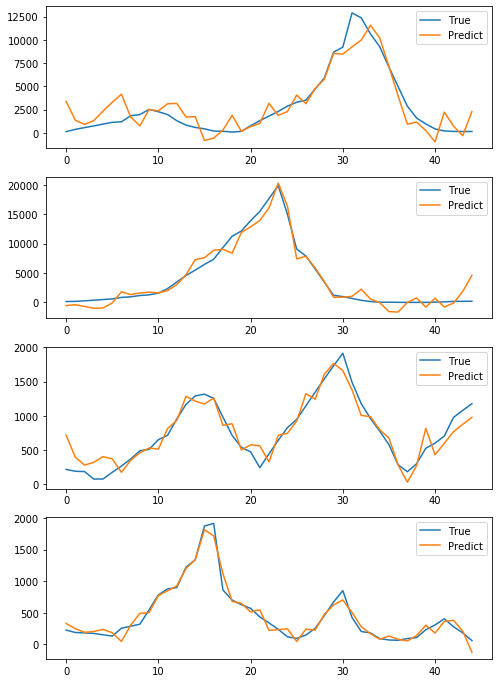

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize = (8, 12))
for i in range(4):
    axs[i].plot(dt['Y{}'.format(i+1)]);
    axs[i].plot(ft.loc[:, i]);
    axs[i].legend(['True', 'Predict']);

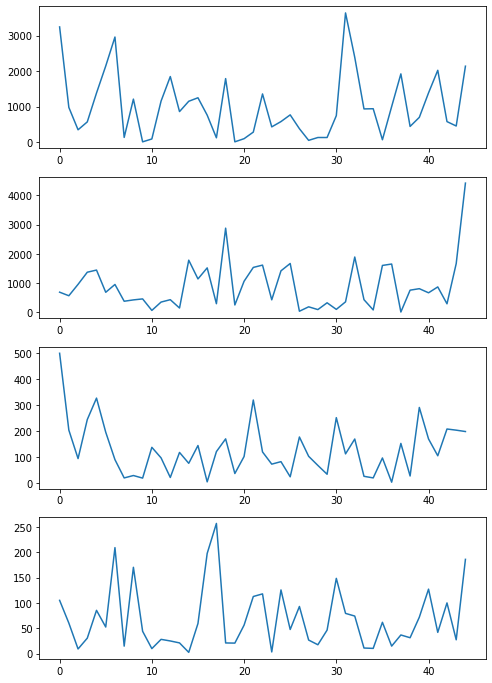

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize = (8, 12))
for i in range(4):
    axs[i].plot(errors.apply(abs).loc[:, 'Y{}'.format(i+1)]);

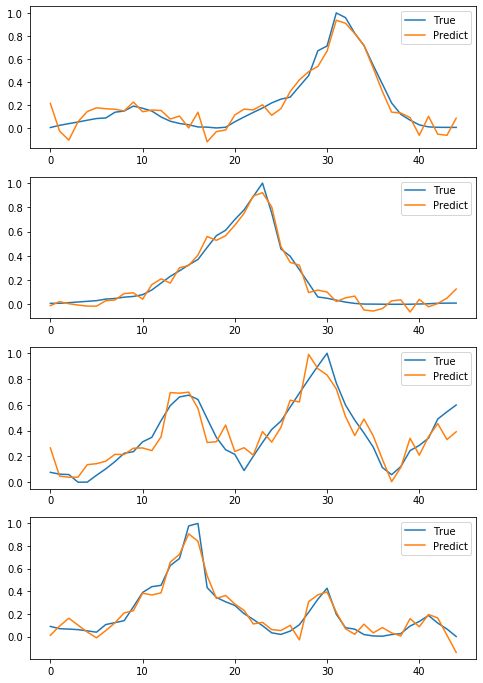

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize = (8, 12))
for i in range(4):
    axs[i].plot(dt_normalized['Y{}'.format(i+1)]);
    axs[i].plot(ft_normalized.loc[:, i]);
    axs[i].legend(['True', 'Predict']);

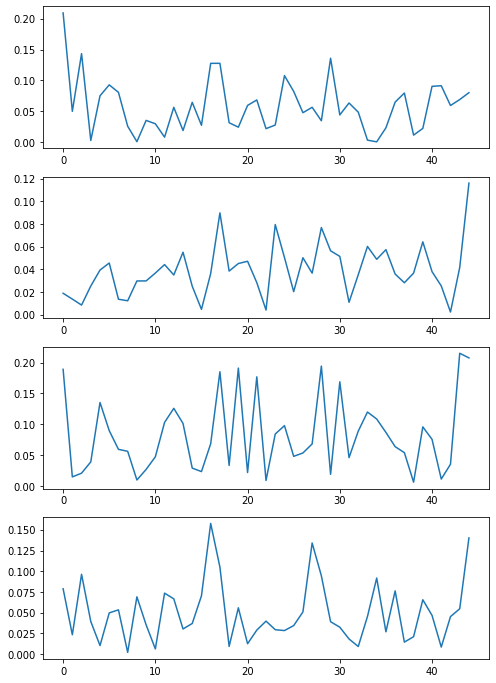

In [12]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize = (8, 12))
for i in range(4):
    axs[i].plot(errors_normalized.apply(abs).loc[:, 'Y{}'.format(i+1)]);